
Wind Predictions - Linear Regression

Variables to Consider 

Windgust, windspeed,	winddir, severerisk, precip, humidity

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [23]:
# Not relative path - change if other user please
data = pd.read_csv('/Users/dltc2020/Documents/Senior-project/Final_Merged_Energy_and_Weather_Data_Formatted.csv')
data['BeginDate'] = pd.to_datetime(data['BeginDate'])

# Create a lagged data point
data['wind_output_lag1'] = data['Wind'].shift(1)

# Create a new column 'Previous_Day' which is one day before time
data['Previous_Day'] = data['BeginDate'] - pd.Timedelta(days=1)
wind_data = data[['BeginDate', 'Wind']].copy()

# Define a function to find the closest Wind value for a given 'Previous_Day' timestamp
def get_previous_day_wind(row, reference_df):
    # Find the Wind value closest to the 'Previous_Day'
    closest_entry = reference_df.iloc[(reference_df['BeginDate'] - row['Previous_Day']).abs().argsort()[:1]]
    if not closest_entry.empty:
        return closest_entry['Wind'].values[0]
    return None



In [32]:
#Splitting the data
train_data = data[data['BeginDate'].dt.day <= 28].copy()
test_data = data[data['BeginDate'].dt.day >= 29].copy()

# Apply the function to get the closest Wind value for each row in the train_data DataFrame
train_data['Previous_Day_Wind'] = train_data.apply(get_previous_day_wind, axis=1, reference_df=wind_data)
test_data['Previous_Day_Wind'] = test_data.apply(get_previous_day_wind, axis=1, reference_df=wind_data)
#Drop if this doesnt work
train_data.dropna(subset=['wind_output_lag1', 'Previous_Day_Wind'], inplace=True)
test_data.dropna(subset=['wind_output_lag1', 'Previous_Day_Wind'], inplace=True)

Seems like wind output lag 2 and direction are not very correlated

In [33]:
# Split the data into training and testing sets (80/20 split)
features = ['wind_output_lag1', 'windspeed', 'windgust', 'cloudcover', 'severerisk', 'precip', 'humidity', 'Previous_Day_Wind']
X_train = train_data[features]
Y_train = train_data['Wind']
X_test = test_data[features]
Y_test = test_data['Wind']

In [34]:
# Initialize and train the Linear Regression
regression = LinearRegression()
regression.fit(X_train, Y_train)

LinearRegression()

In [35]:
#Predict using model and rmse
predictions = regression.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, predictions))
print(f'RMSE: {rmse}')

RMSE: 10.5585858766162


In [36]:
#View coefficients
coefficients = zip(X_train.columns, regression.coef_)

for feature, coef in coefficients:
    print(f"{feature}: {coef}")

wind_output_lag1: 0.9973988325691915
windspeed: -0.02889231571167411
windgust: 0.0892887316177207
cloudcover: 0.0046546707139083964
severerisk: 0.026311468661897403
precip: -3.8605363113978943
humidity: -0.012652107337079192
Previous_Day_Wind: -0.001816536776425435


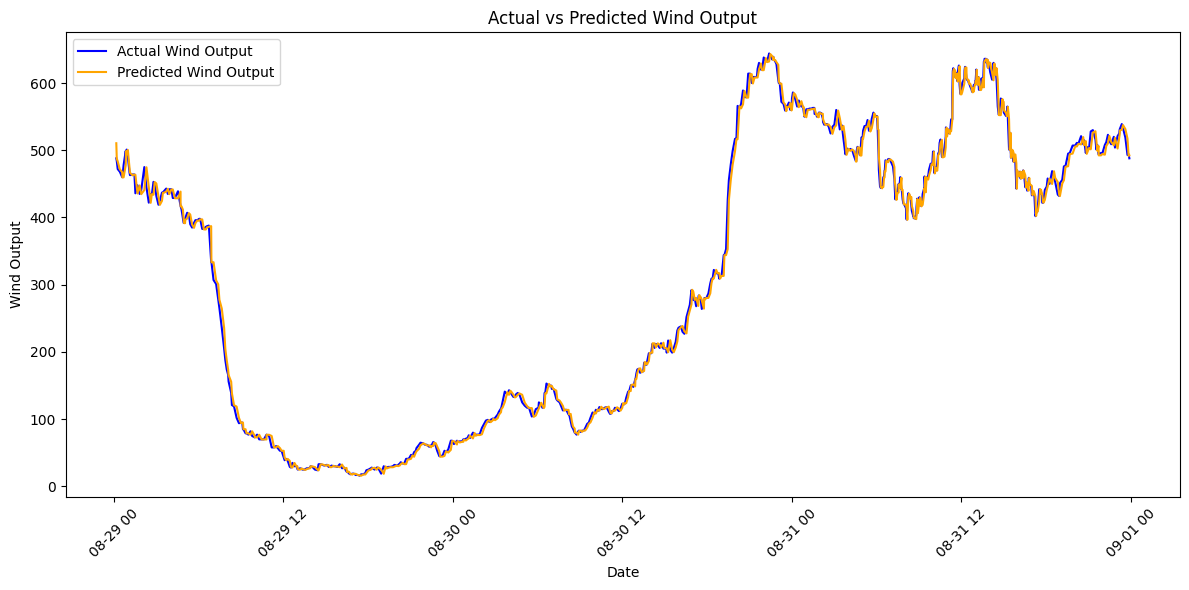

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(test_data['BeginDate'], Y_test, label='Actual Wind Output', color='blue')
plt.plot(test_data['BeginDate'], predictions, label='Predicted Wind Output', color='orange')
plt.xlabel('Date')
plt.ylabel('Wind Output')
plt.title('Actual vs Predicted Wind Output')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()